Weakly-detection for Alzheimer's disease on ADNI dataset
=============

we build a convolutional neural network to train a model to localize the main part of brian in the alzhimer desease from ADNI dataset.


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import numpy as np

import os, sys
import numpy as np
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib

import tensorflow as tf

In [2]:
pickle_file = 'pck1.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_all = save['train_dataset']
  train_labels_all = save['train_labels']
  valid_dataset_all = save['valid_dataset']
  valid_labels_all = save['valid_labels']
  test_dataset_all = save['test_dataset']
  test_labels_all = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset_all.shape, train_labels_all.shape)
  print('Validation set', valid_dataset_all.shape, valid_labels_all.shape)
  print('Test set', test_dataset_all.shape, test_labels_all.shape)

Training set (105, 62, 96, 96) (105,)
Validation set (22, 62, 96, 96) (22,)
Test set (23, 62, 96, 96) (23,)


In [3]:
for n in range(19):
    pickle_file = 'pck%d.pickle' % (n+1)
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset_all = np.vstack((train_dataset_all,save['train_dataset']))
      train_labels_all = np.hstack((train_labels_all,save['train_labels']))
      valid_dataset_all = np.vstack((valid_dataset_all,save['valid_dataset']))
      valid_labels_all = np.hstack((valid_labels_all,save['valid_labels']))
      test_dataset_all = np.vstack((test_dataset_all,save['test_dataset']))
      test_labels_all = np.hstack((test_labels_all,save['test_labels']))
      del save  # hint to help gc free up memory
print('Training set', train_dataset_all.shape, train_labels_all.shape)
print('Validation set', valid_dataset_all.shape, valid_labels_all.shape)
print('Test set', test_dataset_all.shape, test_labels_all.shape)

Training set (2109, 62, 96, 96) (2109,)
Validation set (436, 62, 96, 96) (436,)
Test set (469, 62, 96, 96) (469,)


In [6]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
  
train_dataset, train_labels = randomize(train_dataset, train_labels_all)
test_dataset, test_labels = randomize(test_dataset, test_labels_all)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels_all)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (2109, 1, 96, 96) (2109,)
Test set (469, 1, 96, 96) (469,)
Valid set (436, 1, 96, 96) (436,)


In [7]:
meanVal = np.mean(train_dataset)
train_dataset -= meanVal
test_dataset -= meanVal
valid_dataset -= meanVal

In [8]:
num_labels = 3
num_channels = 1 # grayscale

trY_all = []
for n in train_labels:
    for i in range(slcNum):
        trY_all.append(n)
train_labels = np.asarray(trY_all)

teY_all = []
for n in test_labels:
    for i in range(slcNum):
        teY_all.append(n)
test_labels = np.asarray(teY_all)

vaY_all = []
for n in valid_labels:
    for i in range(slcNum):
        vaY_all.append(n)
valid_labels = np.asarray(vaY_all)

def reformat(dataset, labels):
  dataset = dataset.reshape((dataset.shape[0]*dataset.shape[1],dataset.shape[2],dataset.shape[3]))  
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(1, num_labels+1) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels  = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (2109, 96, 96, 1) (2109, 3)
Test set (469, 96, 96, 1) (469, 3)
Valid set (436, 96, 96, 1) (436, 3)


In [9]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Training set (2109, 96, 96, 1) (2109, 3)
Test set (469, 96, 96, 1) (469, 3)
Valid set (436, 96, 96, 1) (436, 3)


In [10]:
def checkDist(labels):
  nCnt, MCICnt, ADCnt = 0, 0, 0  
  for i in xrange(labels.shape[0]):
        if np.argmax(labels[i]) == 0 :
            nCnt += 1
        elif np.argmax(labels[i]) == 1 :
            MCICnt += 1
        elif np.argmax(labels[i]) == 2 :
            ADCnt += 1
  return nCnt, MCICnt, ADCnt
  
trNl, trMCIl, trADl = checkDist(train_labels)
teNl, teMCIl, teADl = checkDist(test_labels)
vaNl, vaMCIl, vaADl = checkDist(valid_labels)


print('ADNI distribution percentage in train dataset (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (trNl*100./train_labels.shape[0], trMCIl*100./train_labels.shape[0], trADl*100./train_labels.shape[0]))
print('ADNI distribution percentage in test dataset (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (teNl*100./test_labels.shape[0], teMCIl*100./test_labels.shape[0], teADl*100./test_labels.shape[0]))
print('ADNI distribution percentage in valid dataset (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (vaNl*100./valid_labels.shape[0], vaMCIl*100./valid_labels.shape[0], vaADl*100./valid_labels.shape[0]))

ADNI distribution percentage in train dataset (Normal, MCI, AD):45.52% vs. 23.66% vs. 30.82%
ADNI distribution percentage in test dataset (Normal, MCI, AD):31.34% vs. 34.54% vs. 34.12%
ADNI distribution percentage in valid dataset (Normal, MCI, AD):28.67% vs. 38.99% vs. 32.34%


In [11]:
batch_size = 64
num_channels = 1
image_size = 96
numHidden = 1024


# Alexnet convolution layer.
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):

    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    

    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])
    
# Model.
def model(data, keepProb):
    #x = tf.image.resize_images(data, [227, 227])
    
    #conv1       
    #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 2; s_w = 2
    conv1_in = conv(data, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    #lrn1
    #lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1,
                                            depth_radius=radius,
                                            alpha=alpha,
                                            beta=beta,
                                            bias=bias)

    #maxpool1
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #conv2
    #conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)


    #lrn2
    #lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2,
                                              depth_radius=radius,
                                              alpha=alpha,
                                              beta=beta,
                                              bias=bias)

    #maxpool2
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #conv3
    #conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)

    #conv4
    #conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)


    #conv5
    #conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)

    #maxpool5
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    # wd1
    k_h = 3; k_w = 3; c_o = numHidden; s_h = 1; s_w = 1; group = 1
    wdCovn1 = conv(maxpool5, wd1W, wd1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)

    # wd1
    k_h = 3; k_w = 3; c_o = numHidden; s_h = 1; s_w = 1; group = 1
    wdCovn2 = conv(wdCovn1, wd2W, wd2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    
    # GAP
    gap = tf.reduce_mean(wdCovn2, [1,2] )
    gap = tf.nn.dropout(gap, keepProb)

    #fc8
    #fc(num_labels, relu=False, name='fc8')
    logits = tf.nn.xw_plus_b(gap, fc1W, fc1b)
    out = {'wdCovn2': wdCovn2, 'gap': gap, 'logits': logits }

    return out

In [12]:
net_data = np.load("bvlc_alexnet.npy").item()

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_test_dataset  = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    dropPar  = tf.placeholder(tf.float32)
    reguPar  = tf.placeholder(tf.float32)
    
    tmpW1 = (net_data["conv1"][0][:,:,0:1,:] + net_data["conv1"][0][:,:,1:2,:] + net_data["conv1"][0][:,:,2:,:])/3.
    # Variables.
    conv1W = tf.Variable(tmpW1, name="conv1W")
    conv1b = tf.Variable(net_data["conv1"][1], name="conv1b")
    conv2W = tf.Variable(net_data["conv2"][0], name="conv2W")
    conv2b = tf.Variable(net_data["conv2"][1], name="conv2b")
    conv3W = tf.Variable(net_data["conv3"][0], name="conv3W")
    conv3b = tf.Variable(net_data["conv3"][1], name="conv3b")
    conv4W = tf.Variable(net_data["conv4"][0], name="conv4W")
    conv4b = tf.Variable(net_data["conv4"][1], name="conv4b")
    conv5W = tf.Variable(net_data["conv5"][0], name="conv5W")
    conv5b = tf.Variable(net_data["conv5"][1], name="conv5b")
    
    wd1W = tf.Variable(tf.truncated_normal([3, 3, 256, numHidden], stddev=0.1), name="wd1W")
    wd1b = tf.Variable(tf.constant(1.0, shape=[numHidden]), name="wd1b")
    wd2W = tf.Variable(tf.truncated_normal([3, 3, numHidden, numHidden], stddev=0.1), name="wd2W")
    wd2b = tf.Variable(tf.constant(1.0, shape=[numHidden]), name="wd2b")
    fc1W = tf.Variable(tf.truncated_normal([numHidden, num_labels], stddev=0.1), name="fc1W")
    fc1b = tf.Variable(tf.constant(0.0, shape=[num_labels]), name="fc1b")

    actLayers = {
#        'conv3W' : conv3W, 'conv3b' : conv3b,
#        'conv4W' : conv4W, 'conv4b' : conv4b,
        'conv5W' : conv5W, 'conv5b' : conv5b,
        'wd1W' : wd1W, 'wd1b' : wd1b,
        'wd2W' : wd2W, 'wd2b' : wd2b,
        'fc1W' : fc1W, 'fc1b' : fc1b
    }
    actLayersList = [
#        conv3W , conv3b ,
#        conv4W , conv4b ,
        conv5W , conv5b ,
        wd1W , wd1b,
        wd2W , wd2b,
        fc1W , fc1b 
    ]
    
    # Training computation., name="conv1W"
    logits = model(tf_train_dataset, dropPar)['logits']
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    ws   = tf.trainable_variables() 
    lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in ws])*reguPar  
    loss = tf.reduce_mean(loss + lossL2)
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    #learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.97)
    learning_rate = tf.train.exponential_decay(9e-4, global_step, 100, 0.95)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list=actLayersList)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list=actLayersList)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.95 ).minimize(loss, global_step=global_step, var_list=actLayersList)
    #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0)['logits'])
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0)['logits'])  # Save the variables to disk.
    test_features = model(tf_test_dataset, 1.0)['wdCovn2']  # Save the variables to disk.
    saver = tf.train.Saver(actLayers)  

In [13]:
numEp = 10
numItperEp = train_dataset.shape[0] // batch_size + 1
print('number of iteration per epoche: %d'% numItperEp)

num_steps = numItperEp * numEp
newAccval = 0.
ts = time.time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')  
    saver.restore(session, "ftWdAlexnetGray.ckpt")
    print("Model restored.")        
    reguNum = 1e-10  
    dropNum = 0.9
    for epoch in range(numEp): 
        try:     
            if epoch > 60 :
                dropNum -= 0.05
                reguNum /= 2
            else :
                dropNum = 0.9
            avg_loss = 0.
            avg_acc = 0
            # Loop over all batches
            for i in range(numItperEp): 
                randidx  = np.random.randint(train_dataset.shape[0], size=batch_size)
                batch_data = train_dataset[randidx, :, :, :]
                batch_labels = train_labels[randidx, :]  
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                            dropPar : dropNum, reguPar : reguNum}
                # Fit training using batch data
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                # Compute average loss
                avg_loss += l  
                avg_acc += accuracy(predictions, batch_labels)
                #if (i % 50 == 0):
            print('epoch %02d/%02d: | loss: %.4f | accuracy: %.1f%% | time: %.1f (min)' % 
                  (epoch, numEp, avg_loss/(i+1), (avg_acc/(i+1)), (time.time() - ts)/60))
            if (epoch % 1 == 0):
                oldAccval = newAccval   
                num_batch = int(valid_labels.shape[0]/batch_size)
                avgAcc = 0
                for i in range(num_batch): 
                    offset  = i * batch_size
                    batch_data = valid_dataset[offset:(offset+batch_size), :, :, :]
                    avgAcc += accuracy(valid_prediction.eval(feed_dict = {tf_valid_dataset : batch_data}), 
                                             valid_labels[offset:(offset+batch_size), :])            
                newAccval =  avgAcc / num_batch
                print('Validation accuracy: %.1f%%' % newAccval)
                if newAccval-oldAccval < 0.0 and epoch > 50:
                    break
        except KeyboardInterrupt:
            print("interrupted by user")
            break                    
    # Save the variables to disk.
    save_path = saver.save(session, "ftWdAlexnetGray.ckpt")
    print("Model saved in file: %s" % save_path)
    
    num_batch = int(test_labels.shape[0]/batch_size)
    avgAcc = 0
    testPred = []
    features = []
    features_labels = []   
    for i in range(num_batch): 
        offset  = i * batch_size
        batch_data = test_dataset[offset:(offset+batch_size), :, :, :]
        features_labels.append(test_labels[offset:(offset+batch_size), :])   
        features.append(session.run(test_features, feed_dict={tf_test_dataset : batch_data,})) 
        testPred.append(test_prediction.eval(feed_dict = {tf_test_dataset : batch_data}))
        avgAcc += accuracy(testPred[i], test_labels[offset:(offset+batch_size), :])
    print (" Test accuracy: %.3f" % (avgAcc / num_batch))    
    gapW = [v for v in tf.trainable_variables() if v.name == "fc1W:0"][0]
    gapW = session.run(gapW)    

number of iteration per epoche: 33
Initialized
Model restored.
epoch 00/10: | loss: 0.6752 | accuracy: 92.7% | time: 3.3 (min)
Validation accuracy: 74.2%
epoch 01/10: | loss: 0.2622 | accuracy: 95.1% | time: 6.6 (min)
Validation accuracy: 69.5%
epoch 02/10: | loss: 0.2195 | accuracy: 94.6% | time: 10.3 (min)
Validation accuracy: 74.2%
epoch 03/10: | loss: 0.1799 | accuracy: 95.6% | time: 14.1 (min)
Validation accuracy: 71.4%
epoch 04/10: | loss: 0.3415 | accuracy: 94.6% | time: 18.0 (min)
Validation accuracy: 72.9%
epoch 05/10: | loss: 0.1272 | accuracy: 96.4% | time: 21.6 (min)
Validation accuracy: 76.0%
epoch 06/10: | loss: 0.0734 | accuracy: 97.5% | time: 25.2 (min)
Validation accuracy: 73.2%
epoch 07/10: | loss: 0.0632 | accuracy: 98.1% | time: 29.1 (min)
Validation accuracy: 75.3%
epoch 08/10: | loss: 0.0526 | accuracy: 98.3% | time: 33.1 (min)
Validation accuracy: 79.2%
epoch 09/10: | loss: 0.0523 | accuracy: 98.1% | time: 36.9 (min)
Validation accuracy: 74.5%
Model saved in file

In [14]:
features = np.asarray(features)
testPred = np.asarray(testPred)
features_labels = np.asarray(features_labels)
features_labels = np.reshape(features_labels, (features_labels.shape[0]*features_labels.shape[1], features_labels.shape[2]))   
features = np.reshape(features, (features.shape[0]*features.shape[1], features.shape[2], features.shape[3], features.shape[4]))   
testPred = np.reshape(testPred, (testPred.shape[0]*testPred.shape[1], testPred.shape[2]))   
testDataset = test_dataset + meanVal
print(features.shape)
print(testPred.shape)
print(gapW.shape)

(448, 5, 5, 1024)
(448, 3)
(1024, 3)


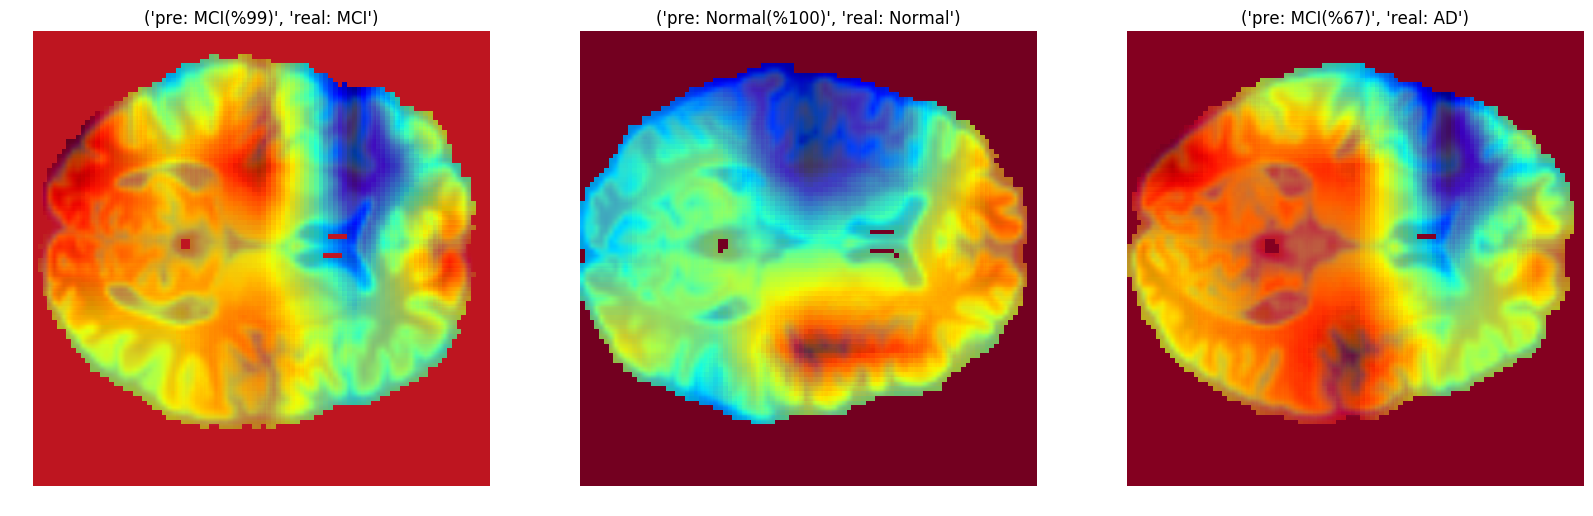

In [27]:
from PIL import Image
import os
import sys
import scipy.misc
%matplotlib inline

numCol = 3

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=numCol)

im_samples = []
for i, j in enumerate(np.sort(np.random.randint(0, features_labels.shape[0], size=numCol))):
    im = np.asarray(testDataset[j,:,:,0])
    pre1Alz = np.str(int(testPred[j,0]*100))
    pre2Alz = np.str(int(testPred[j,1]*100))
    pre3Alz = np.str(int(testPred[j,2]*100))
    lbl = np.argmax(test_labels[j])
    if lbl == 0:
        tgtAlz = 'Normal'
    elif lbl == 1:
        tgtAlz = 'MCI'
    elif lbl == 2 :
        tgtAlz = 'AD'
    lbl = np.argmax(testPred[j])
    if lbl == 0:
        preAlz = 'Normal(%'+pre1Alz+')'
    elif lbl == 1:
        preAlz = 'MCI(%'+pre2Alz+')'
    elif lbl == 2 :
        preAlz = 'AD(%'+pre3Alz+')'
    #print(pre1Alz,pre2Alz,pre3Alz,tgtAlz)
    im_samples.extend([j])
    convLay = features[j]
    camAns = np.zeros(((96, 96, 1024)))
    for n in range(1024):
        camAns[:,:,n] = scipy.misc.imresize(convLay[:,:,n], (96, 96) )
    camAns = np.reshape(camAns, (96*96, 1024))
    camW = np.transpose(gapW)[np.argmax(testPred[j])]
    camAns = np.dot(camAns, camW )
    camAns = np.reshape(camAns, (96, 96) )
    camAns[im <= 0] = 0
    camVis = (camAns-camAns.min())/(camAns.max()-camAns.min())
    ax[i].axis('off')
    ax[i].set_title(('pre: '+preAlz,'real: '+tgtAlz), loc='center')
    ax[i].imshow(im)
    ax[i].imshow(camVis, cmap=plt.cm.jet, alpha=0.75, interpolation='nearest' )